In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
import pandeia
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, psf

In [2]:
print(os.environ['pandeia_refdata'])

/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman


In [3]:
psf_list = glob(os.path.join(os.environ['pandeia_refdata'], 'roman', 'wfi', 'psfs', 'wfi_imaging-f062*'))
psf_list.sort()

pprint(psf_list)

['/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.4465.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.4725.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.5002.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.5294.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.5603.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.5931.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.6277.fits',
 '/data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_0.6644.fits',
 '/data/

In [4]:
from astropy.io import fits

with fits.open(psf_list[-1]) as hdul:
   hdul.info()
   data = hdul[0].data
   header = hdul[0].header

pprint(header)

Filename: /data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_2.1897.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      59   (195, 195)   float64   
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  195                                                  
NAXIS2  =                  195                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 2.18969236369454E-06 / Weighted mean wavelength in meters             
DIFFLMT =   0.1869280867341966 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    5 / Oversampling factor for FFTs in computation    
DET_SAMP=    

In [5]:
wavelengths = ['0.4465e-6','0.4725e-6', '0.5002e-6', '0.5294e-6', '0.5603e-6', '0.5931e-6', '0.6277e-6', '0.6644e-6', '0.7032e-6', '0.7443e-6', '0.7878e-6', '0.8338e-6', '0.8826e-6', '0.9341e-6', '0.9887e-6', '1.0465e-6', '1.1077e-6', '1.1724e-6', '1.2409e-6', '1.3134e-6', '1.3902e-6', '1.4714e-6', '1.5574e-6', '1.6484e-6', '1.7447e-6', '1.8467e-6', '1.9546e-6', '2.0688e-6', '2.1897e-6']

In [13]:
from webbpsf import roman

wfi = roman.WFI()
wfi.filter = 'F062'
wfi.options = {'source_offset_r': 0.,
               'source_offset_theta': 0.,
               'pupil_shift_x': 0.,
               'pupil_shift_y': 0.,
               'output_mode': 'oversampled',
               'jitter': 'gaussian',
               'jitter_sigma': 0.012}

x, y = psf.get_random_position()
detector = psf.get_random_detector(wfi)

# wfi.detector = detector
# wfi.detector_position = (x, y)

for wl in tqdm(wavelengths):
    wfi.calc_psf(oversample=5, 
                       fov_arcsec=4.29,
                       monochromatic=float(wl),
                       normalize='first',
                       overwrite=True,
                       outfile=f'webbpsf_{wl[:-3]}.fits')

Detector position: 1306, 1587
Detector: SCA17


  0%|          | 0/29 [00:00<?, ?it/s]

Attempted to get aberrations at wavelength 4.5e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
Attempted to get aberrations at wavelength 4.5e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
Attempted to get aberrations at wavelength 4.5e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
Attempted to get aberrations at wavelength 4.5e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
Attempted to get aberrations at wavelength 4.5e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
  3%|▎         | 1/29 [00:02<01:03,  2.29s/it]Attempted to get aberrations at wavelength 4.7e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
Attempted to get aberrations at wavelength 4.7e-07 outside the range of the reference data; clipping to closest wavelength 4.8e-07
Attempted to get aberrations at wavel

In [14]:
# wfi = roman.WFI()
# wfi.filter = 'F062'

# cube = wfi.calc_datacube(wavelengths=wavelengths, fov_pixels=195, oversample=5)

In [15]:
with fits.open('webbpsf_2.1897.fits') as hdul:
   hdul.info()
   data = hdul[0].data
   header = hdul[0].header

pprint(header)

Filename: webbpsf_2.1897.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      54   (195, 195)   float64   
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  195                                                  
NAXIS2  =                  195                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN =           2.1897E-06 / Weighted mean wavelength in meters             
DIFFLMT =   0.1869287386248418 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    5 / Oversampling factor for FFTs in computation    
DET_SAMP=                    5 /

In [16]:
replicated_psfs = glob('webbpsf_*.fits')
replicated_psfs.sort()
pprint(replicated_psfs)

['webbpsf_0.4465.fits',
 'webbpsf_0.4725.fits',
 'webbpsf_0.5002.fits',
 'webbpsf_0.5294.fits',
 'webbpsf_0.5603.fits',
 'webbpsf_0.5931.fits',
 'webbpsf_0.6277.fits',
 'webbpsf_0.6644.fits',
 'webbpsf_0.7032.fits',
 'webbpsf_0.7443.fits',
 'webbpsf_0.7878.fits',
 'webbpsf_0.8338.fits',
 'webbpsf_0.8826.fits',
 'webbpsf_0.9341.fits',
 'webbpsf_0.9887.fits',
 'webbpsf_1.0465.fits',
 'webbpsf_1.1077.fits',
 'webbpsf_1.1724.fits',
 'webbpsf_1.2409.fits',
 'webbpsf_1.3134.fits',
 'webbpsf_1.3902.fits',
 'webbpsf_1.4714.fits',
 'webbpsf_1.5574.fits',
 'webbpsf_1.6484.fits',
 'webbpsf_1.7447.fits',
 'webbpsf_1.8467.fits',
 'webbpsf_1.9546.fits',
 'webbpsf_2.0688.fits',
 'webbpsf_2.1897.fits']


Filename: /data/bwedig/STScI/ref_data/pandeia_data-3.0_roman/roman/wfi/psfs/wfi_imaging-f062-f087-f106-f129-f146-f158_1.4714.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      59   (195, 195)   float64   
Filename: webbpsf_1.4714.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      54   (195, 195)   float64   


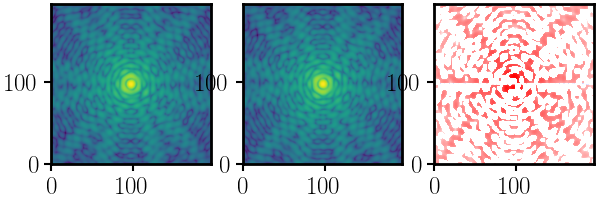

In [30]:
i = 21

with fits.open(psf_list[i]) as hdul:
    hdul.info()
    actual = hdul[0].data
with fits.open(replicated_psfs[i]) as hdul:
    hdul.info()
    replica = hdul[0].data
difference = actual - replica
m_chi_square = stats.chi_square(observed=replica, expected=actual)

f, ax = plt.subplots(1, 3)

ax[0].imshow(np.log10(actual))
ax[1].imshow(np.log10(replica))
ax[2].imshow(np.log10(difference), cmap='bwr')
plt.show()

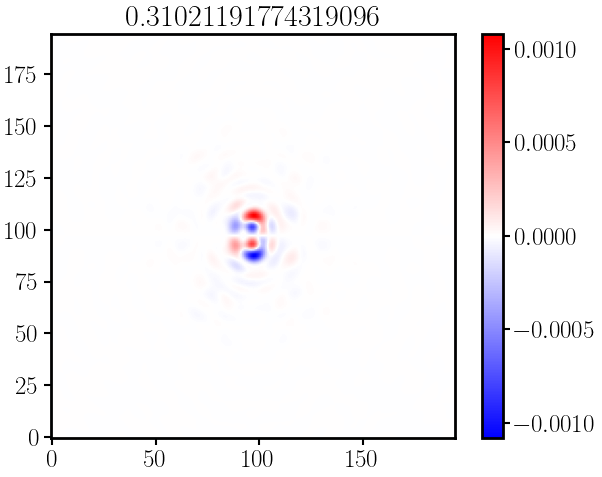

In [31]:
plt.imshow(difference, cmap='bwr')
plt.colorbar()
plt.title(stats.chi_square(observed=replica, expected=actual))
plt.show()

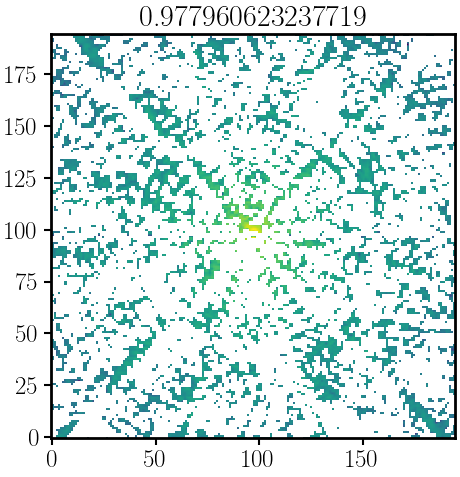

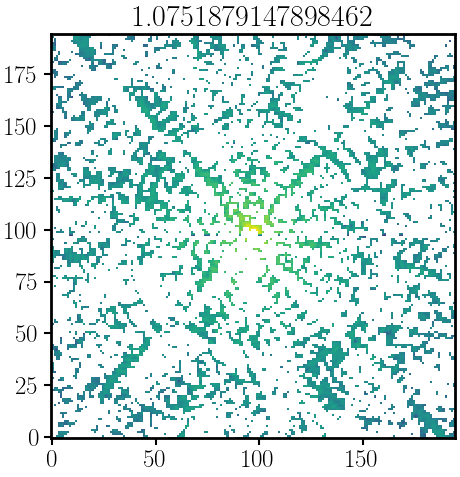

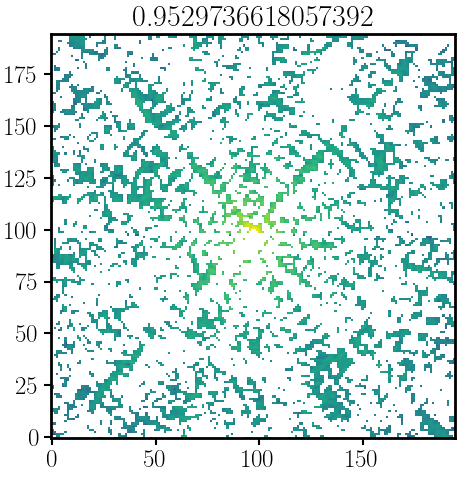

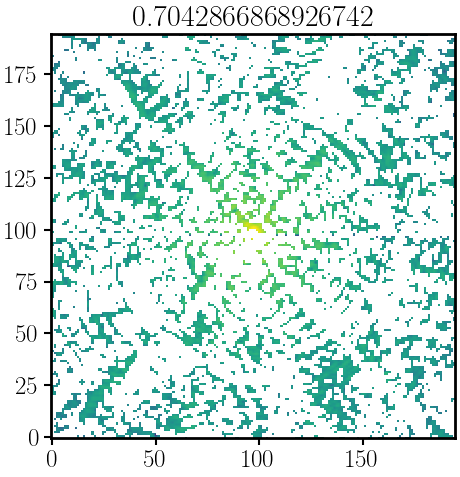

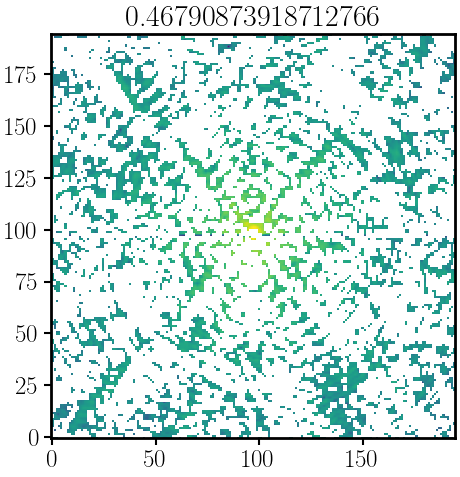

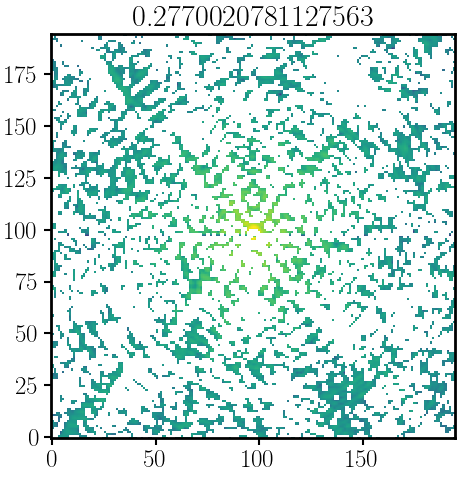

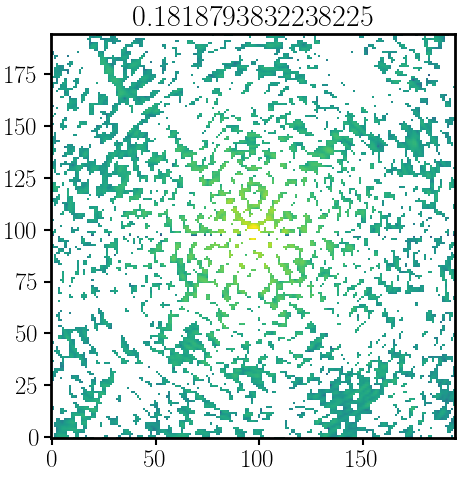

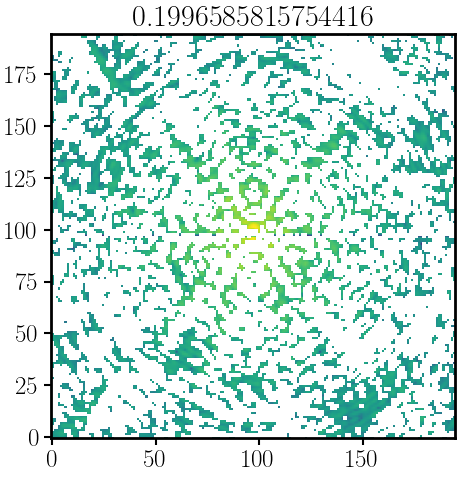

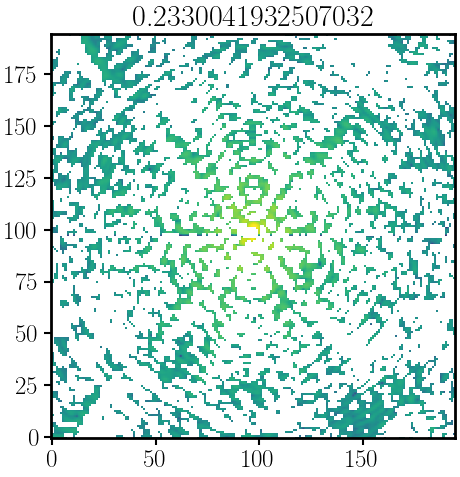

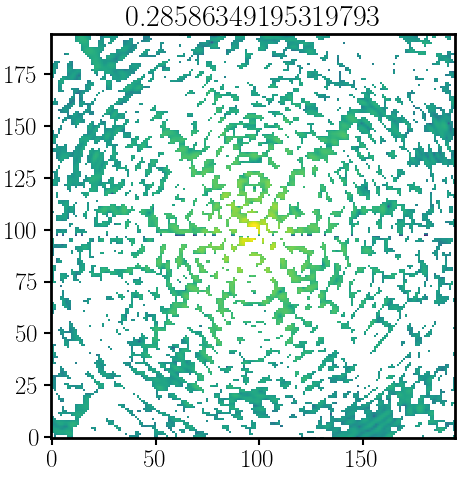

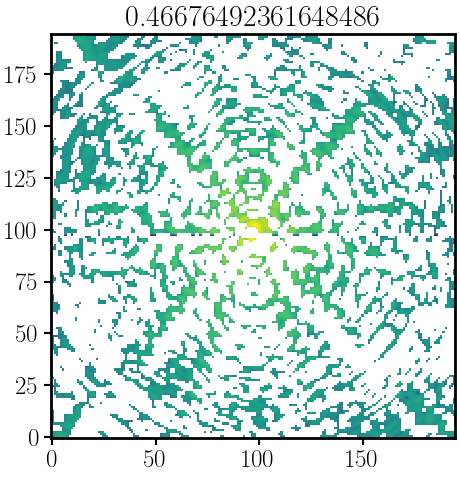

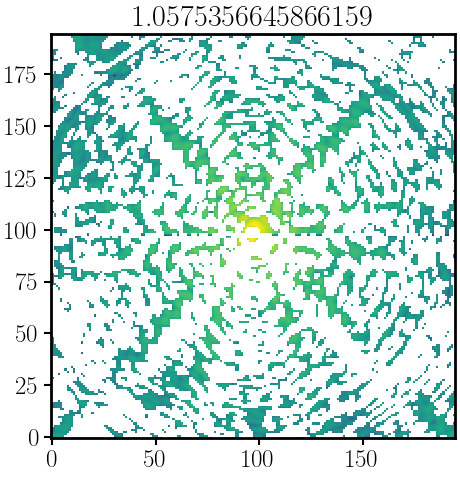

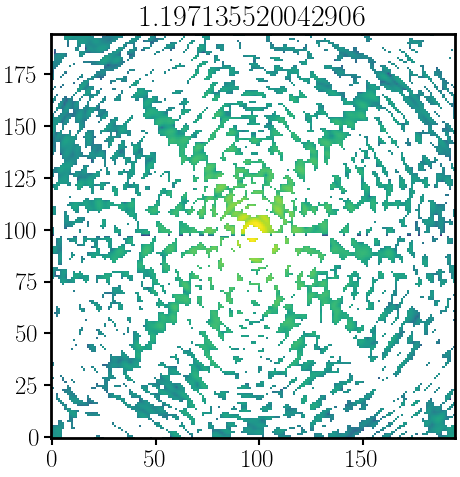

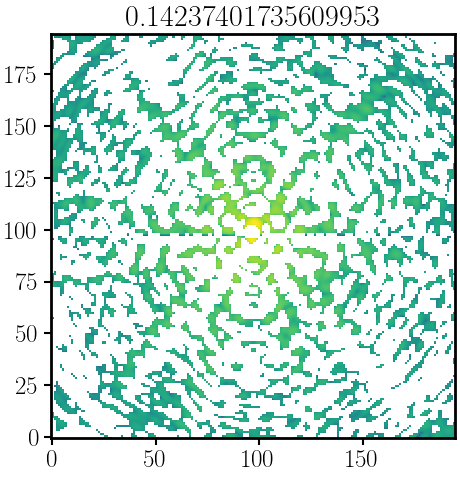

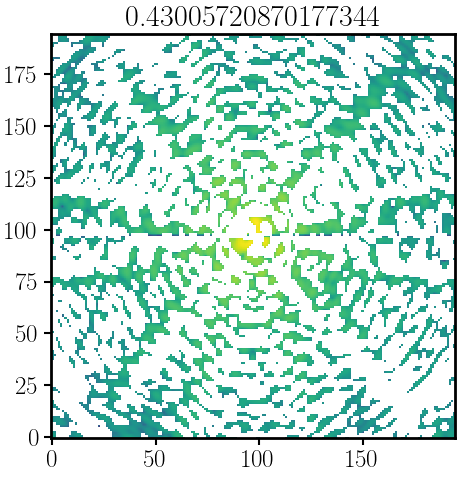

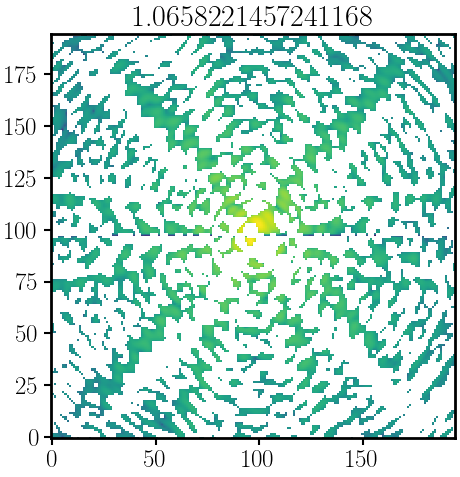

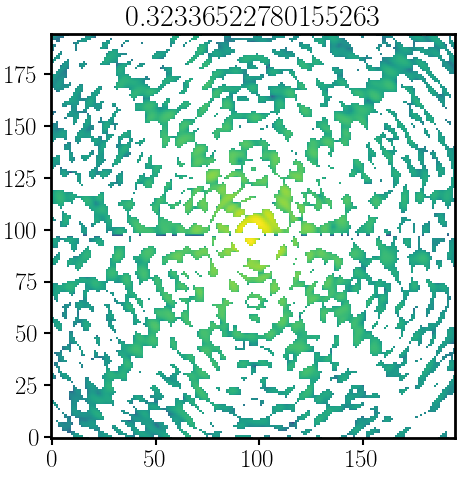

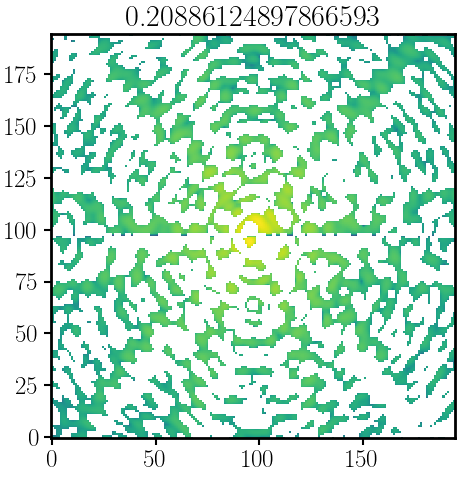

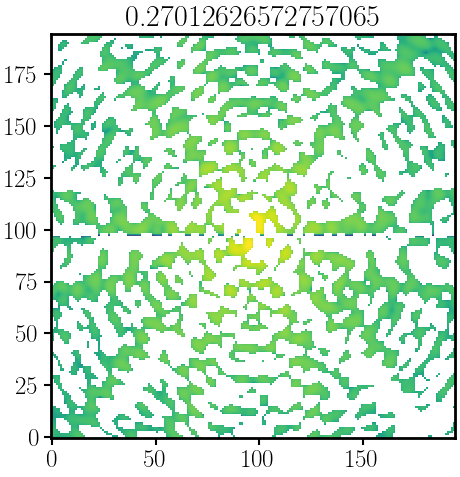

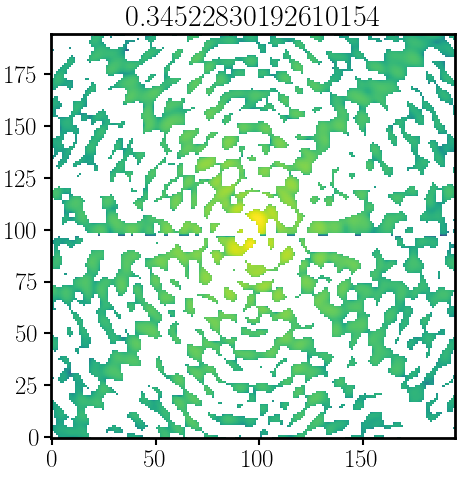

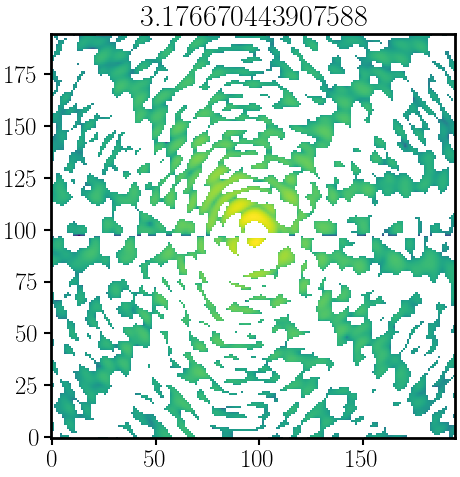

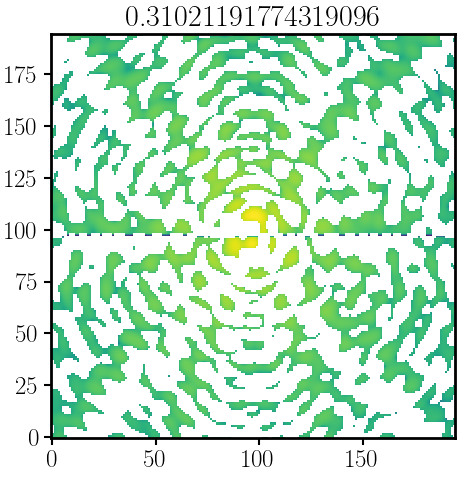

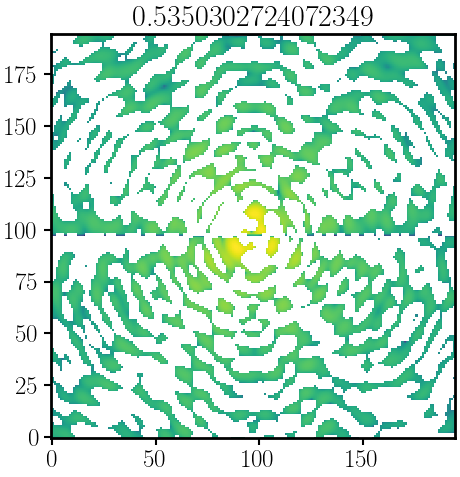

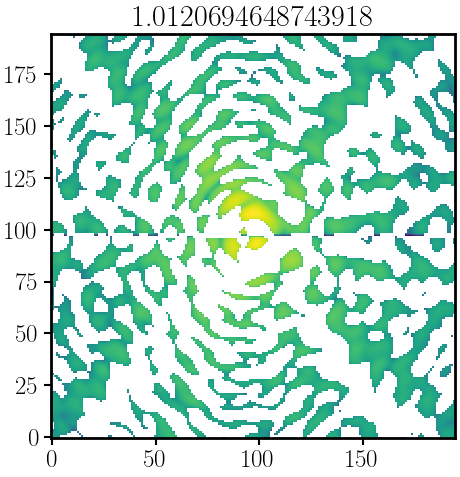

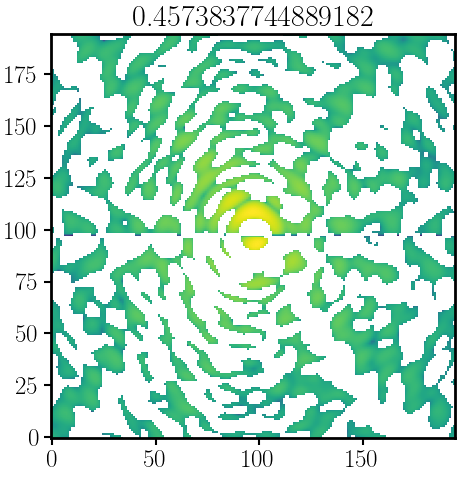

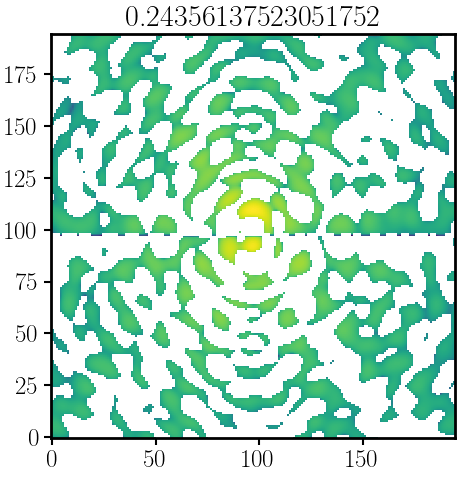

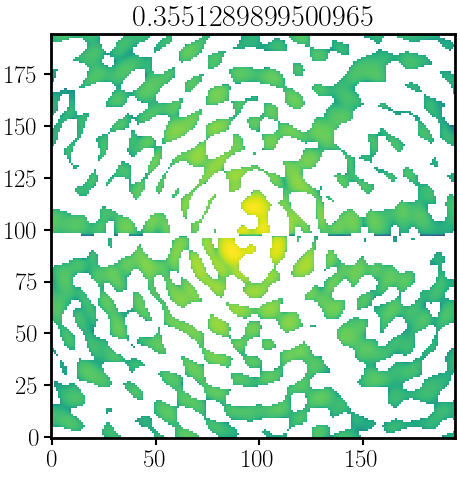

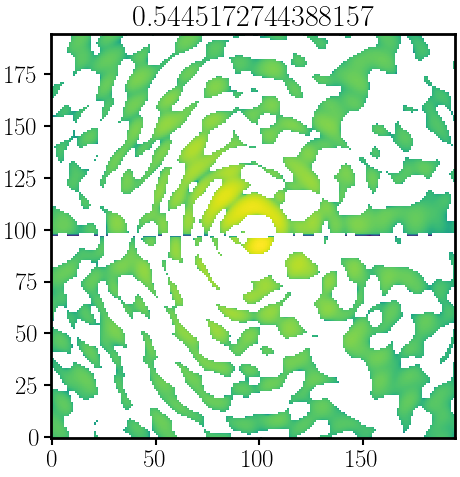

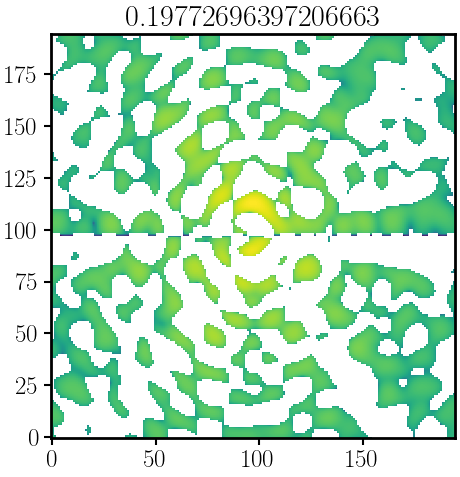

In [19]:
for i, _ in enumerate(psf_list):
    with fits.open(psf_list[i]) as hdul:
        actual = hdul[0].data
    with fits.open(replicated_psfs[i]) as hdul:
        replica = hdul[0].data
    difference = actual - replica
    m_chi_square = stats.chi_square(observed=replica, expected=actual)
    f, ax = plt.subplots()
    ax.imshow(np.log10(difference))
    ax.set_title(m_chi_square)